In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time

from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

from mykaggle.metric.mse import rmsle
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [3]:
settings = yaml.safe_load('''
name: '003_group_kfold'
competition: atmacup8
seed: 1019
training:
    num_folds: 5
    num_rounds: 1000
    early_stopping_rounds: 100
    verbose_eval: 20
lgbm_params:
    objective: binary
    learning_rate: 0.05
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: "None"
''')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
fix_seed(settings['seed'])

In [5]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [6]:
df_train = pd.read_csv(datadir / 'train.csv')
df_test = pd.read_csv(datadir / 'id_test.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((8359, 16), (8360, 12))

In [7]:
df_train.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,NaN,NaN
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+


In [8]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
splitter = GroupKFold(n_splits=5)

In [9]:
le = LabelEncoder()
df_train.loc[:, 'Publisher'] = le.fit_transform(df_train.loc[:, 'Publisher'])

In [10]:
df_train.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,LEGO Batman: The Videogame,Wii,NaN,Action,282,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,145,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+
2,LEGO Batman: The Videogame,PSP,NaN,Action,282,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+
3,Combat,2600,NaN,Action,26,117,7,0,1,125,NaN,NaN,NaN,NaN,NaN,NaN
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,282,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+


In [11]:
splits = splitter.split(df_train, groups=df_train.loc[:, 'Publisher'])
splits = list(splits)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
for train_idx, valid_idx in splits:
    train, valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    print(train.loc[:, 'Global_Sales'].mean(), valid.loc[:, 'Global_Sales'].mean())
    print(train.loc[:, 'Global_Sales'].median(), valid.loc[:, 'Global_Sales'].median())

65.7209510991476 53.97667464114833
17.0 21.0
47.93315388066397 125.11722488038278
16.0 26.0
67.22730671452071 47.952153110047846
19.0 13.0
70.42889187976671 35.14772727272727
19.0 13.0
65.54844497607655 54.66008378216637
17.0 20.0


/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
for train_idx, valid_idx in splits:
    train, valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    print(train.loc[:, 'Global_Sales'].mean(), valid.loc[:, 'Global_Sales'].mean())
    print(train.loc[:, 'Global_Sales'].median(), valid.loc[:, 'Global_Sales'].median())

65.7209510991476 53.97667464114833
17.0 21.0
47.93315388066397 125.11722488038278
16.0 26.0
67.22730671452071 47.952153110047846
19.0 13.0
70.42889187976671 35.14772727272727
19.0 13.0
65.54844497607655 54.66008378216637
17.0 20.0


/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
import pickle
pickle.dump(splits, open(datadir / 'group_5fold.pkl', 'wb'))

# 検証

In [14]:
import pickle
splits = pickle.load(open(datadir / 'group_5fold.pkl', 'rb'))

In [16]:
for train_idx, valid_idx in splits:
    train, valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    print(train.shape, valid.shape)
    print(train.loc[:, 'Global_Sales'].mean(), valid.loc[:, 'Global_Sales'].mean())

(6687, 16) (1672, 16)
65.7209510991476 53.97667464114833
(6687, 16) (1672, 16)
47.93315388066397 125.11722488038278
(6687, 16) (1672, 16)
67.22730671452071 47.952153110047846
(6687, 16) (1672, 16)
70.42889187976671 35.14772727272727
(6688, 16) (1671, 16)
65.54844497607655 54.66008378216637


In [17]:
# 169 を抜いたため再度作成する

In [26]:
df_train.iloc[0:2]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,LEGO Batman: The Videogame,Wii,NaN,Action,282,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,145,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+


In [38]:
df_train.shape

(8359, 16)

In [39]:
new_splits = []
for train_idx, valid_idx in splits:
    new_train_idx = np.array([idx for idx in train_idx if idx != 8358])
    new_valid_idx = np.array([idx for idx in valid_idx if idx != 8358])
#     new_train_idx[new_train_idx > 169] = new_train_idx[new_train_idx > 169] - 1
#     new_valid_idx[new_valid_idx > 169] = new_valid_idx[new_valid_idx > 169] - 1
    new_splits.append((new_train_idx, new_valid_idx))

In [56]:
new_splits = []
for train_idx, valid_idx in splits:
    new_train_idx = np.array([idx for idx in train_idx if idx != 169])
    new_valid_idx = np.array([idx for idx in valid_idx if idx != 169])
    new_train_idx[new_train_idx > 169] = new_train_idx[new_train_idx > 169] - 1
    new_valid_idx[new_valid_idx > 169] = new_valid_idx[new_valid_idx > 169] - 1
    new_splits.append((new_train_idx, new_valid_idx))

In [29]:
for train_idx, valid_idx in new_splits:
    train, valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    print(train.shape, valid.shape)
    print(train.loc[:, 'Global_Sales'].mean(), valid.loc[:, 'Global_Sales'].mean())

(6686, 16) (1672, 16)
64.48683816930901 58.95035885167464
(6686, 16) (1672, 16)
55.00134609632067 96.88098086124401
(6686, 16) (1672, 16)
66.25441220460664 51.88217703349282
(6687, 16) (1671, 16)
68.27501121579184 43.78755236385398
(6687, 16) (1671, 16)
62.87812172872738 65.38479952124476


In [67]:
# import pickle
# pickle.dump(new_splits, open(datadir / 'b_group_5fold.pkl', 'wb'))

In [19]:
import pickle
splits = pickle.load(open(datadir / 'group_5fold.pkl', 'rb'))

In [12]:
def show_venn(train, test, column, i = None):
    train_ = train.copy()
    test_ = test.copy()
    if i is not None:
        plt.subplot(6, 4, i)
    test_[column] = test_[column].fillna(0)
    train_[column] = train_[column].fillna(0)
    venn2([set(train_[column]), set(test_[column])])
    title = column + f'; train - test: {len(set(train_[column]) - set(test_[column]))}\n'
    title += f'train null: {np.sum(train_[column].isna())}, {np.mean(train_[column].isna())*100:.1f}%\n'
    title += f'test null: {np.sum(test_[column].isna())}, {np.mean(test_[column].isna())*100:.1f}%\n'
    plt.title(title)

In [18]:
df_train = pd.read_csv(datadir / 'country_prob_train.csv')
train_idx, valid_idx = splits[4]
tt, tv = df_train.iloc[train_idx], df_train.iloc[valid_idx]

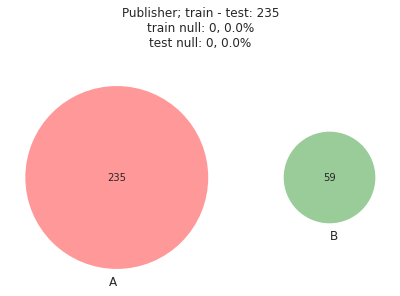

In [14]:
show_venn(tt, tv, 'Publisher')
plt.tight_layout()

In [20]:
for train_idx, valid_idx in splits:
    print(169 in train_idx, 169 in valid_idx)

True False
True False
True False
False True
True False


In [43]:
import pickle
splits = pickle.load(open(datadir / 'group_5fold.pkl', 'rb'))

In [11]:
tr_idx, va_idx = splits[1]

In [28]:
top30_index = df_train.loc[va_idx].sort_values('Global_Sales', ascending=False).head(30).index

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
import random
sampled_index = random.sample(list(top30_index), 15)

In [32]:
sampled_index

[170,
 3075,
 3390,
 5593,
 7393,
 3331,
 5594,
 200,
 3487,
 4507,
 164,
 1039,
 212,
 6121,
 5352]

In [57]:
tr_idx, va_idx = splits[1]
tr_idx.shape, va_idx.shape

((6687,), (1672,))

In [58]:
new_tr_idx = tr_idx.tolist()
new_tr_idx.extend(sampled_index)
new_tr_idx = np.array(new_tr_idx)
new_va_idx = np.array([i for i in va_idx if i not in sampled_index])
new_tr_idx.shape, new_va_idx.shape

((6702,), (1657,))

In [40]:
tr_idx.tolist().extend(sampled_index)

In [42]:
tr_idx.shape

(6687,)

In [59]:
new_fold1_split = (new_tr_idx, new_va_idx)

In [60]:
splits[1] = new_fold1_split

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
for train_idx, valid_idx in splits:
    train, valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    print(train.shape, valid.shape)
    print(train.loc[:, 'Global_Sales'].mean(), valid.loc[:, 'Global_Sales'].mean())

(6687, 16) (1672, 16)
65.7209510991476 53.97667464114833
(6702, 16) (1657, 16)
53.11041480155178 104.87567893783947
(6687, 16) (1672, 16)
67.22730671452071 47.952153110047846
(6687, 16) (1672, 16)
70.42889187976671 35.14772727272727
(6688, 16) (1671, 16)
65.54844497607655 54.66008378216637


In [62]:
# import pickle
# pickle.dump(splits, open(datadir / 'c_group_5fold.pkl', 'wb'))